# Growth dynamics

In this tutorial, we'll use Pycea to explore tumor growth dynamics in spatially-resolved lineage tracing data from [Koblan et al. 2025](https://www.science.org/doi/10.1126/science.adx3800). 

This study profiled mouse 4T1 breast carcinoma tumors with the PEtracer system which can be read out using either scRNA-seq or MERFISH-style imaging. Here we will focus on three tumors sections from mouse 3 tumor 1, which were profiled with imaging. The full dataset is available on [Figshare](https://figshare.com/s/8e9d573deca3d44235fe).

In [2]:
import pycea as py
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 600
edit_cmap = mcolors.ListedColormap(
    ["white", "lightgray", "#CD2626", "#E69F00", "#FFE600", "#009E73", "#83A4FF", "#1874CD", "#8E0496", "#DB65D2"]
)

# Auto reload
%load_ext autoreload
%autoreload 2

The 4T1 data can be easily loaded using {func}`pycea.datasets.koblan25()`.

In [ ]:
tdata = py.datasets.koblan25()
tdata

TreeData object with n_obs × n_vars = 145954 × 175
    obs: 'sample', 'cell', 'cellBC', 'fov', 'centroid_x', 'centroid_y', 'centroid_z', 'n_layers', 'volume', 'n_genes_by_counts', 'total_counts', 'cell_subtype', 'true_proportion', 'diffusion_proportion', 'background_proportion', 'total_density', 'tumor', 'tumor_boundary_dist', 'within_tumor', 'lung_boundary_dist', 'type', 'clone', 'detection_rate', 'tree', 'fitness', 'clade', 'character_dist_of_relatives', 'local_character_diversity', 'hotspot_module', 'phase', 'edit_frac', 'leiden_cluster'
    uns: 'clone_characters', 'clone_colors', 'hotspot_module_colors', 'leiden_cluster_colors', 'within_tumor_colors'
    obsm: 'X_resolVI', 'X_umap', 'characters', 'module_scores', 'resolvi_celltypes', 'spatial', 'spatial_grid', 'spatial_overlay', 'subtype_density'
    obst: 'tree'

## Clades

First let's identify clades in the tumor that share a common ancestor at day five using {func}`pycea.tl.clades`.

In [5]:
py.tl.clades(tdata, depth=5, depth_key="time", update=False)

We can then use {func}`pycea.get.palette` to create a rainbow color scheme to visualize the clades.

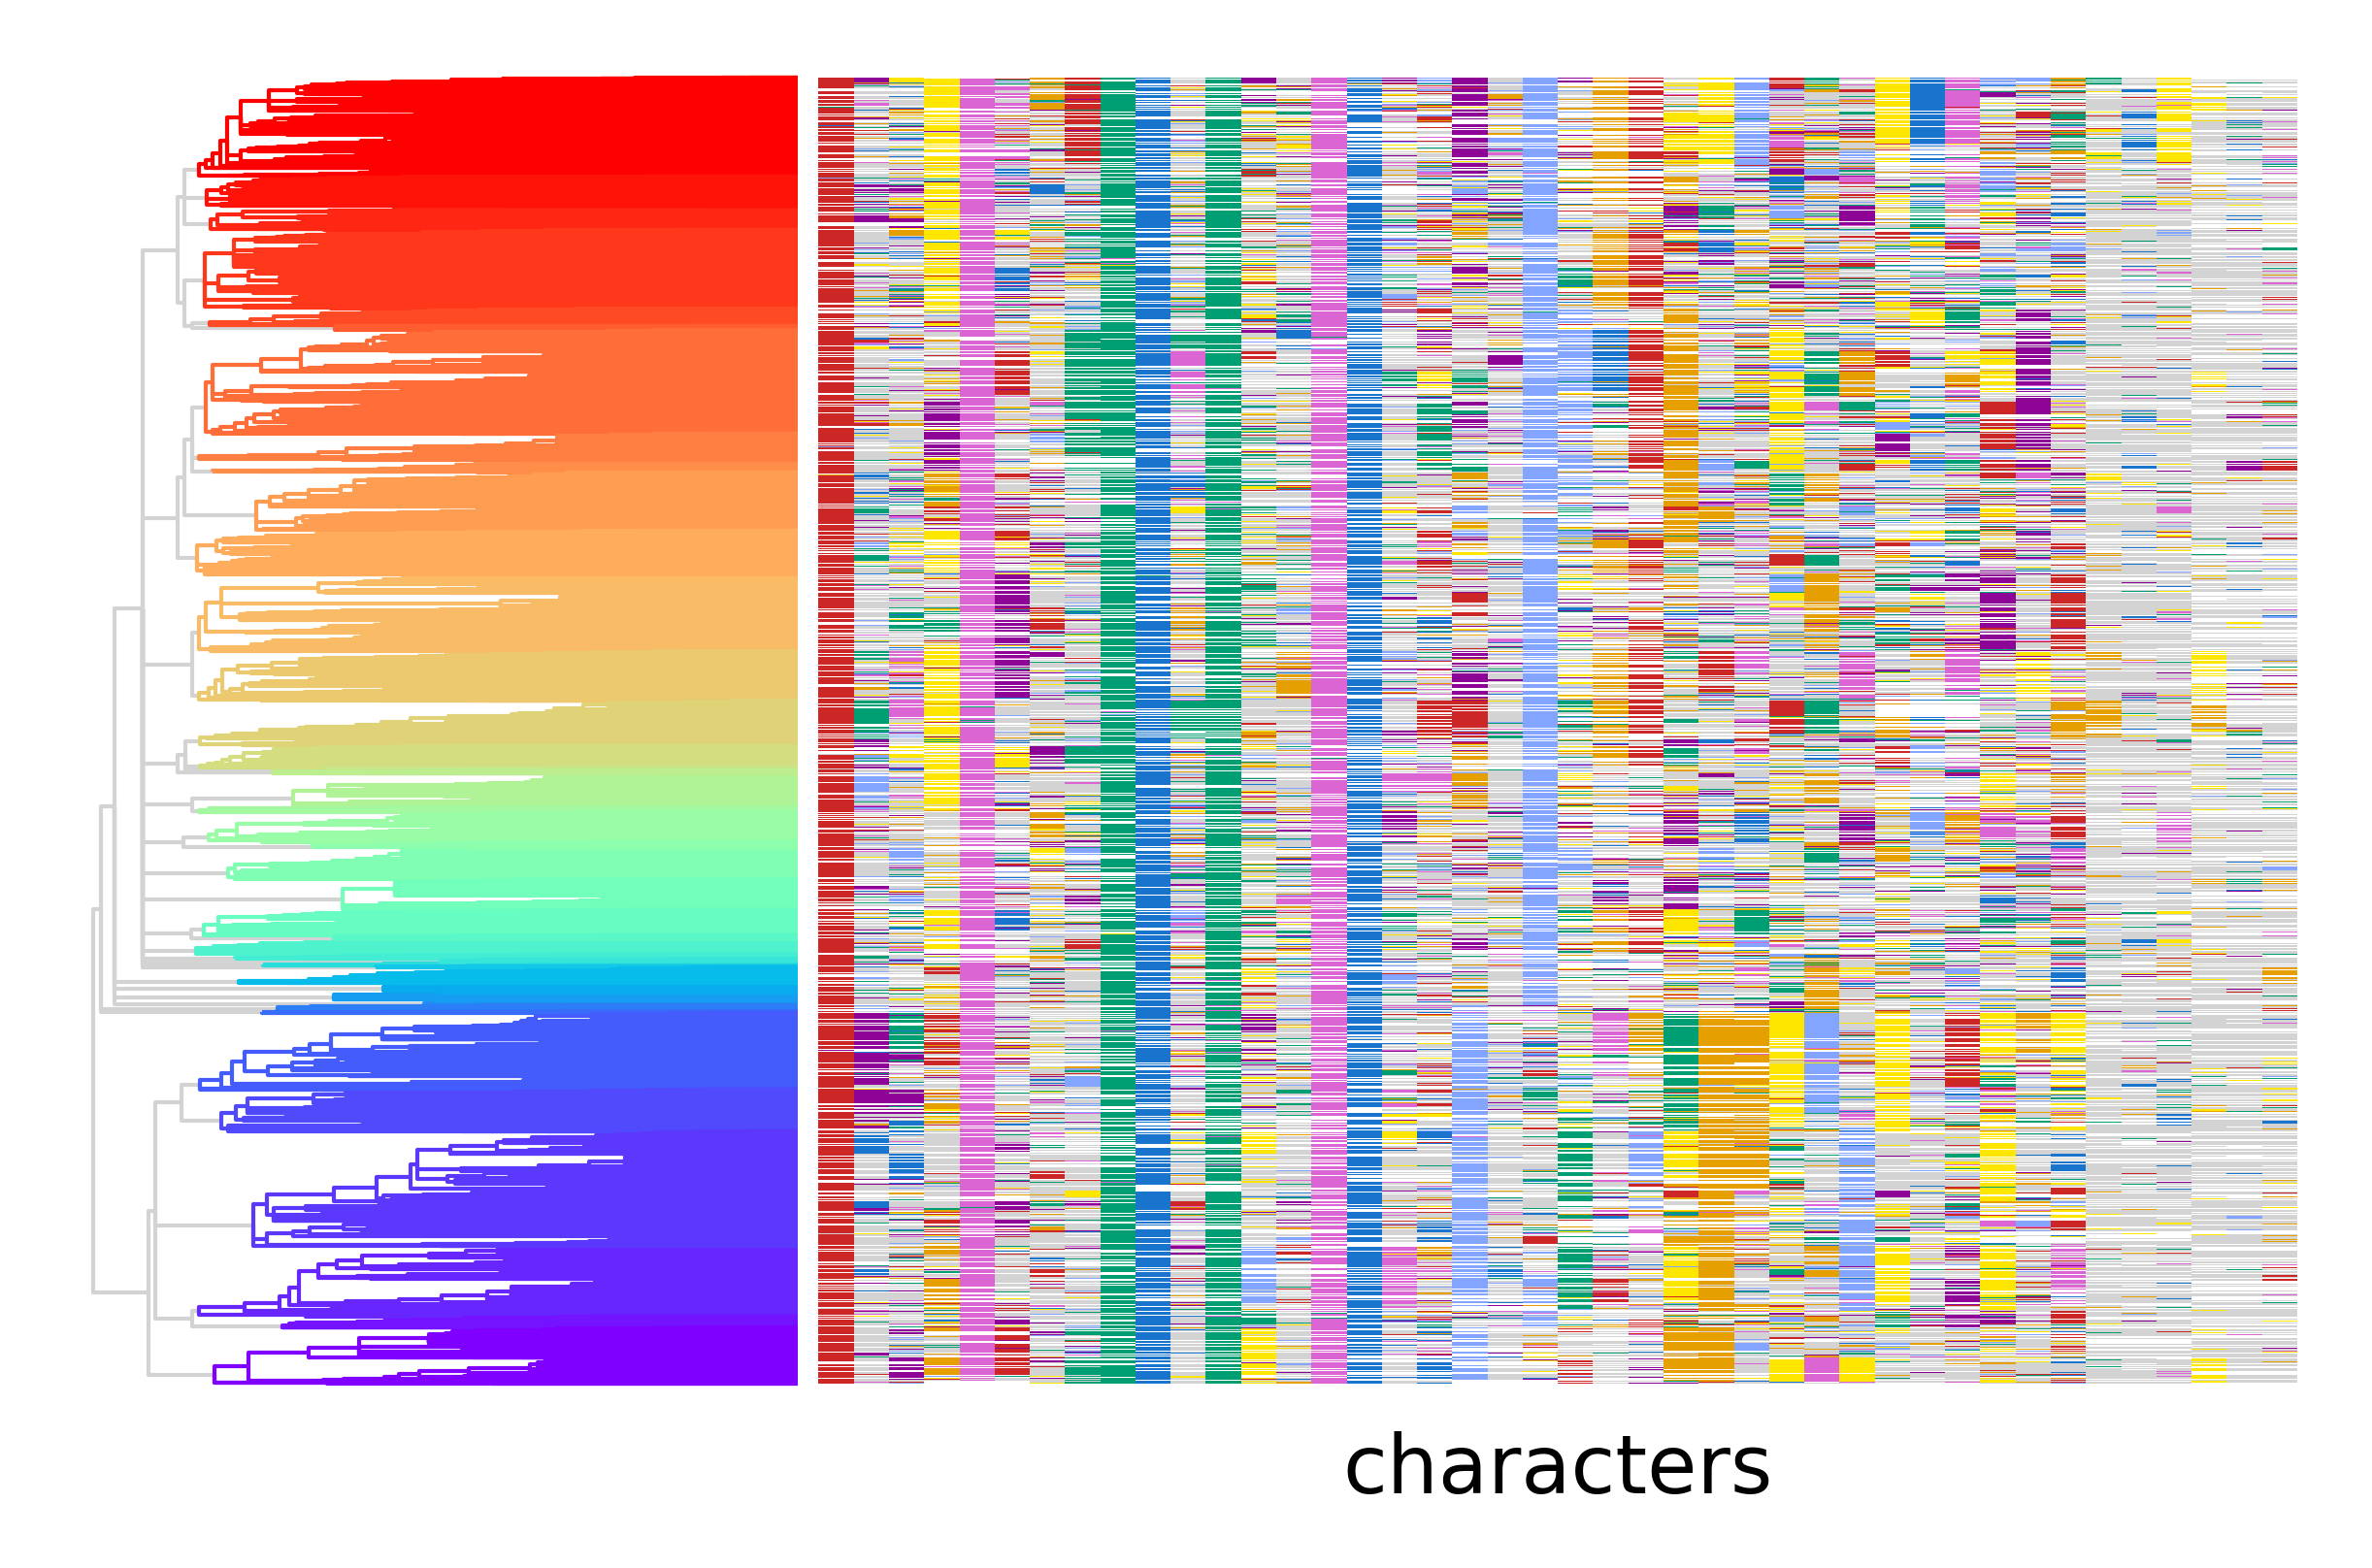

In [6]:
clade_palette = py.get.palette(tdata, key="clade", cmap="rainbow")
py.pl.tree(tdata, depth_key="time", branch_color="clade", palette=clade_palette)
py.pl.annotation(tdata, keys="characters", cmap=edit_cmap, legend=False);

Using this color scheme we can also visualize the spatial distribution of clades in each tumor section. The grey points are stromal cells and tumor cells that are not include in the lineage tree.

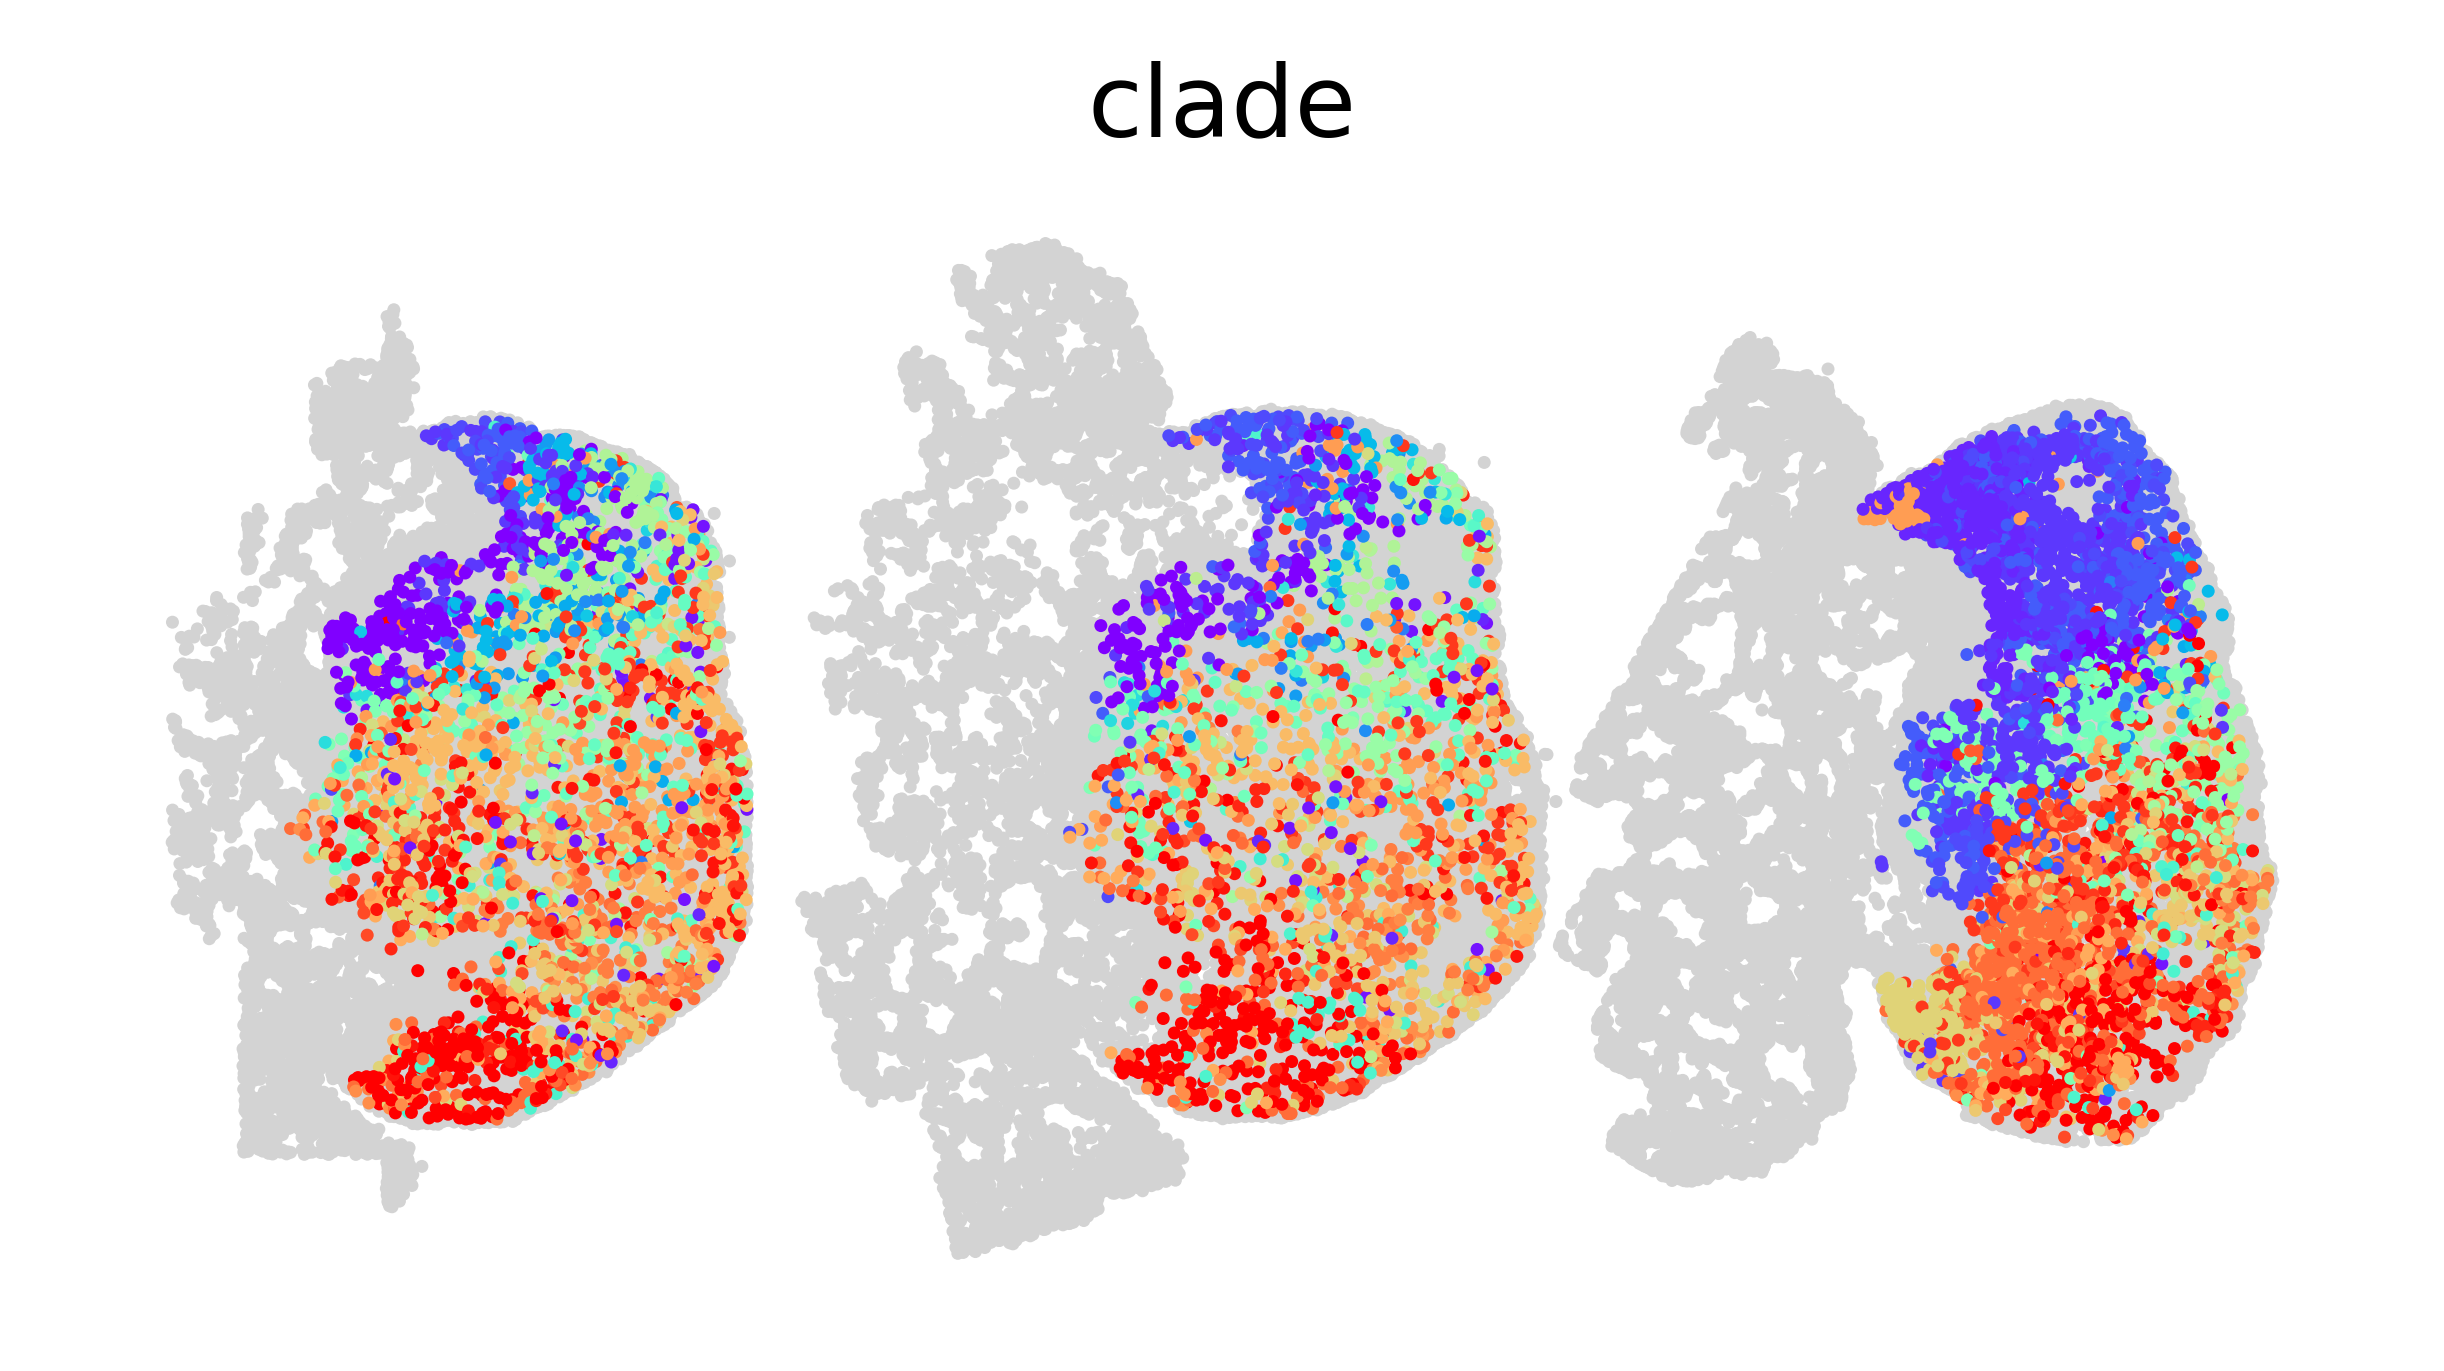

In [17]:
sc.pl.spatial(tdata, color="clade", spot_size=40, frameon=False, legend_loc=None);

## Number of extant cells

Now, let's use {func}`pycea.tl.n_extant` examine how the number of extant cells in each clade changes over time. This function counts the number of branches that are alive at time discrete points specified by `bins` with the option to group branches by a categorical variable(s) specified by `groupby`.

In [8]:
n_extant = py.tl.n_extant(tdata, depth_key="time", groupby="clade", bins=20, dropna=True, copy=True)
n_extant.sort_values(["clade", "time"]).head(10)

time  n_extant  tree clade
903   0.00         0  tree     0
904   1.75         0  tree     0
905   3.50         1  tree     0
906   5.25         1  tree     0
907   7.00         3  tree     0
908   8.75         4  tree     0
909  10.50         4  tree     0
910  12.25         7  tree     0
911  14.00        16  tree     0
912  15.75        23  tree     0

The number of extant cells can be visualized using {func}`pycea.pl.n_extant` with the `stat` specifying the statistic to use, one of `count`, `fraction`, or `percent`.

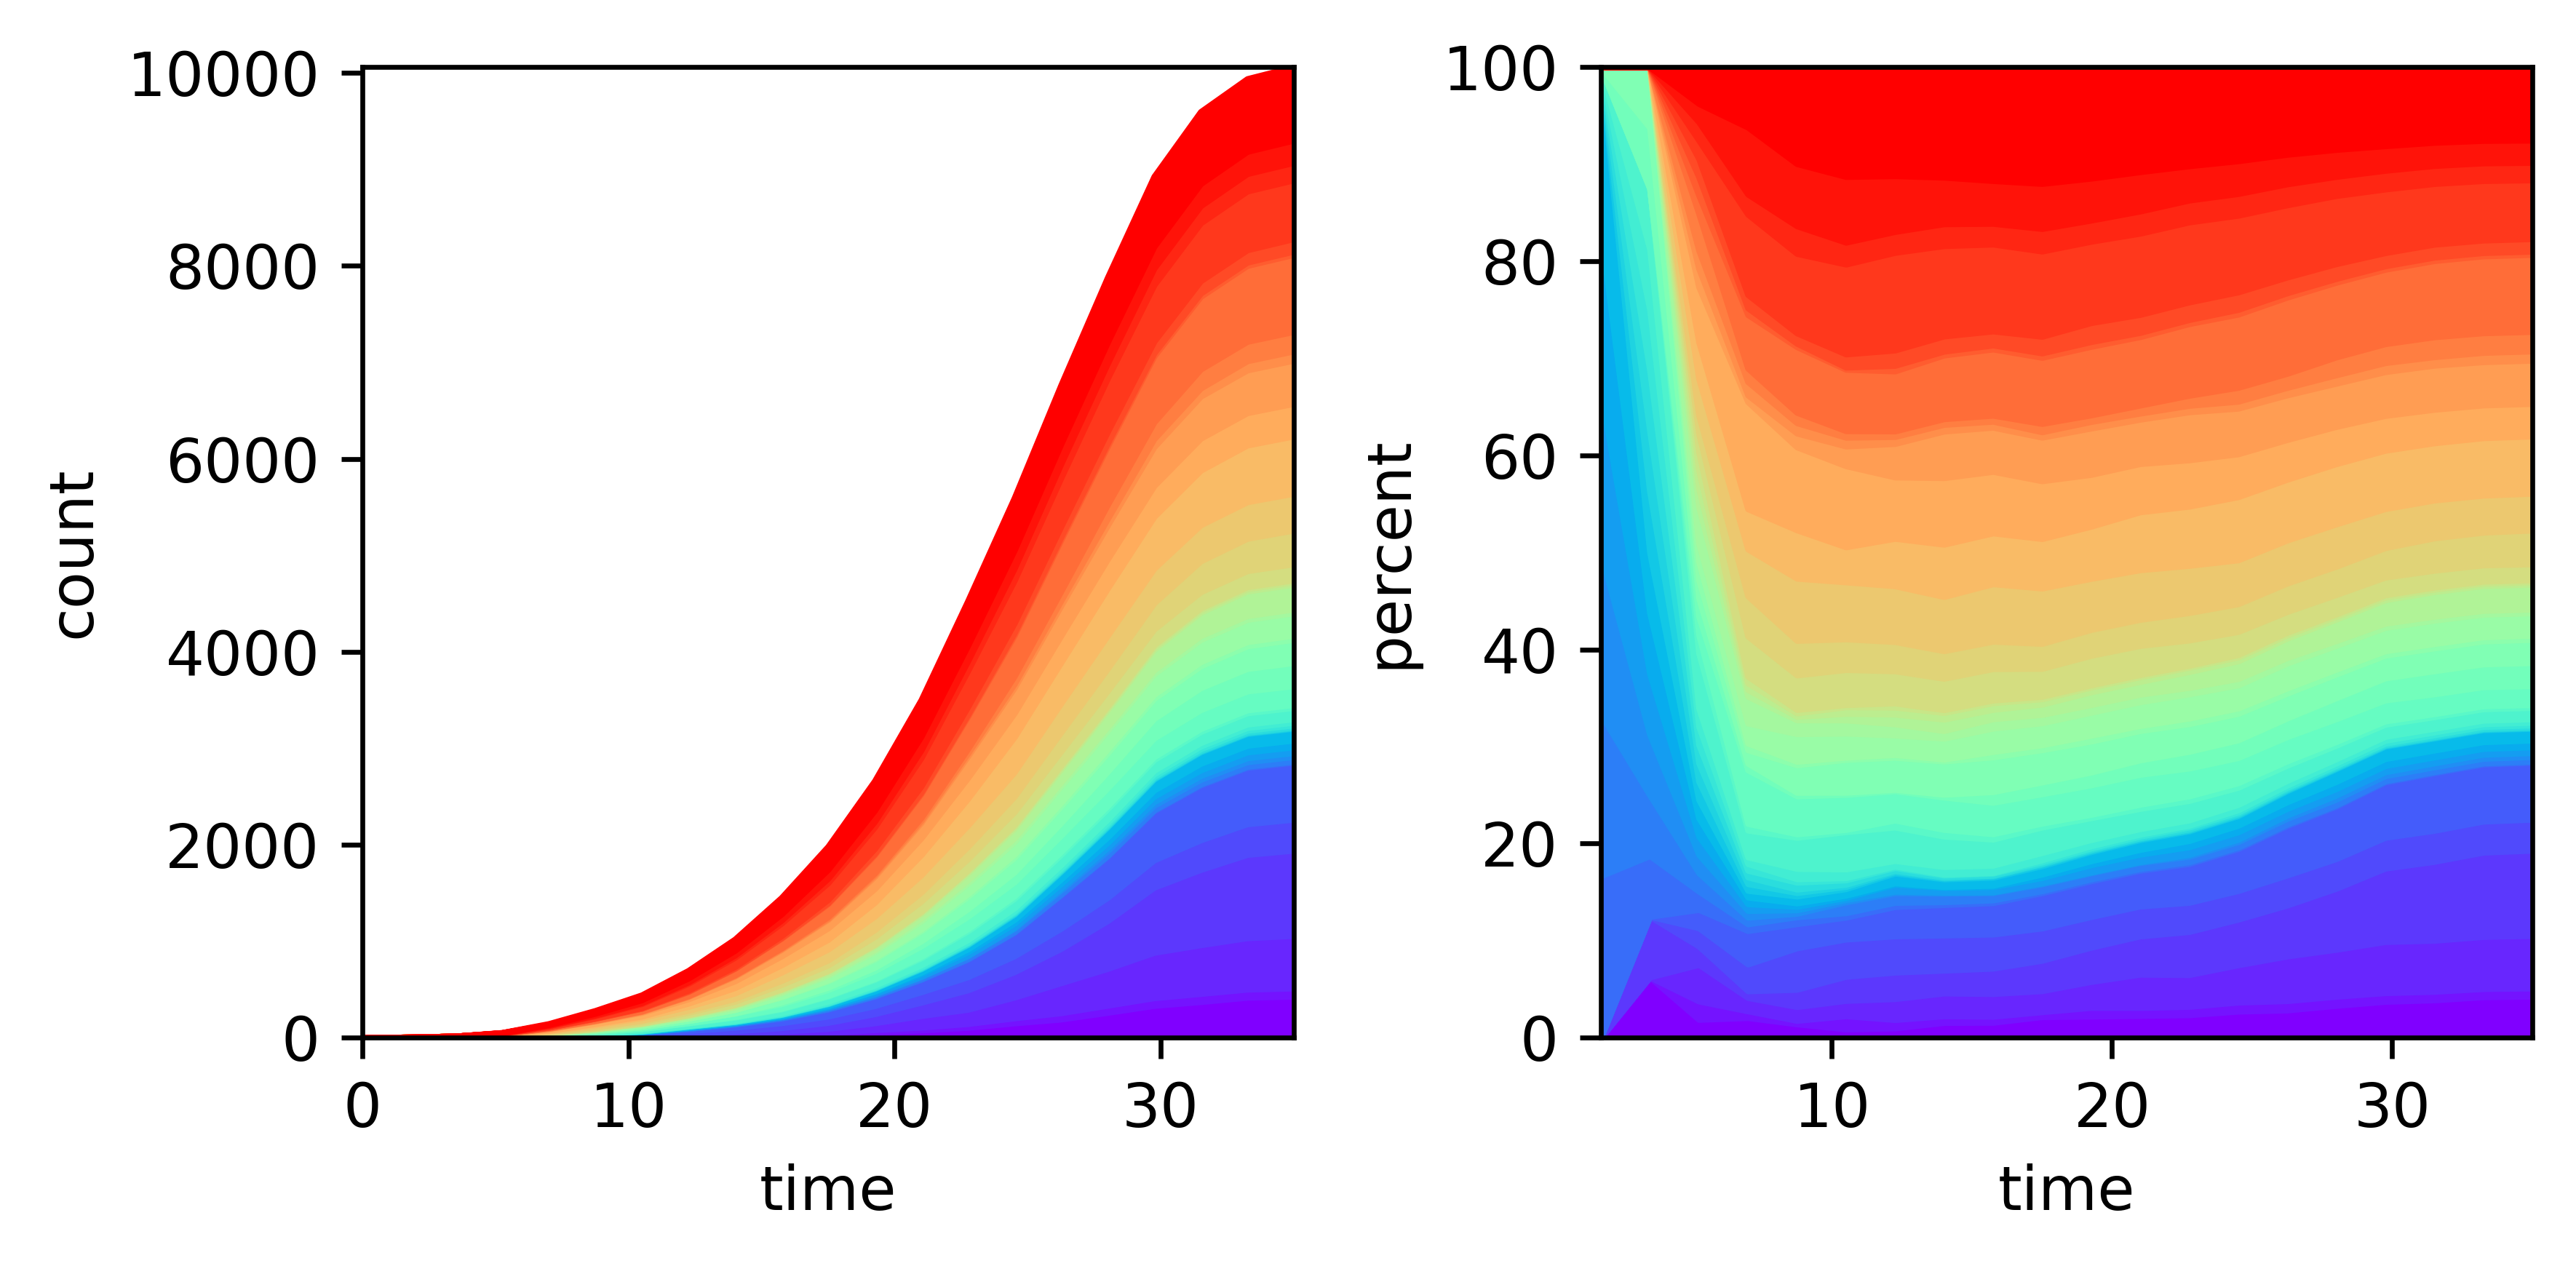

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
py.pl.n_extant(tdata, ax=axes[0])
py.pl.n_extant(tdata, ax=axes[1], stat="percent")
plt.tight_layout()

This plot reveals that the blue and purple clades expand more rapidly than the other clades.

## Fitness

Another way to look at growth is phylogenetic fitness estimates based on tree topology. The {func}`pycea.tl.fitness` function can be used to compute the Selection-Biased Diffusion (SBD) or Local Branching Index (LBI) fitness metrics proposed by [Neher et al. 2014](https://elifesciences.org/articles/03568). We'll use SBD here since it is more accurate and can be computed in a reasonable amount of time for a tree of this size.

In [10]:
py.tl.fitness(tdata, depth_key="time", method="sbd")

Now let's plot the tree annotating the leaves with the estimated fitness values. As expected, the clades that expand more rapidly tend to have higher fitness values.

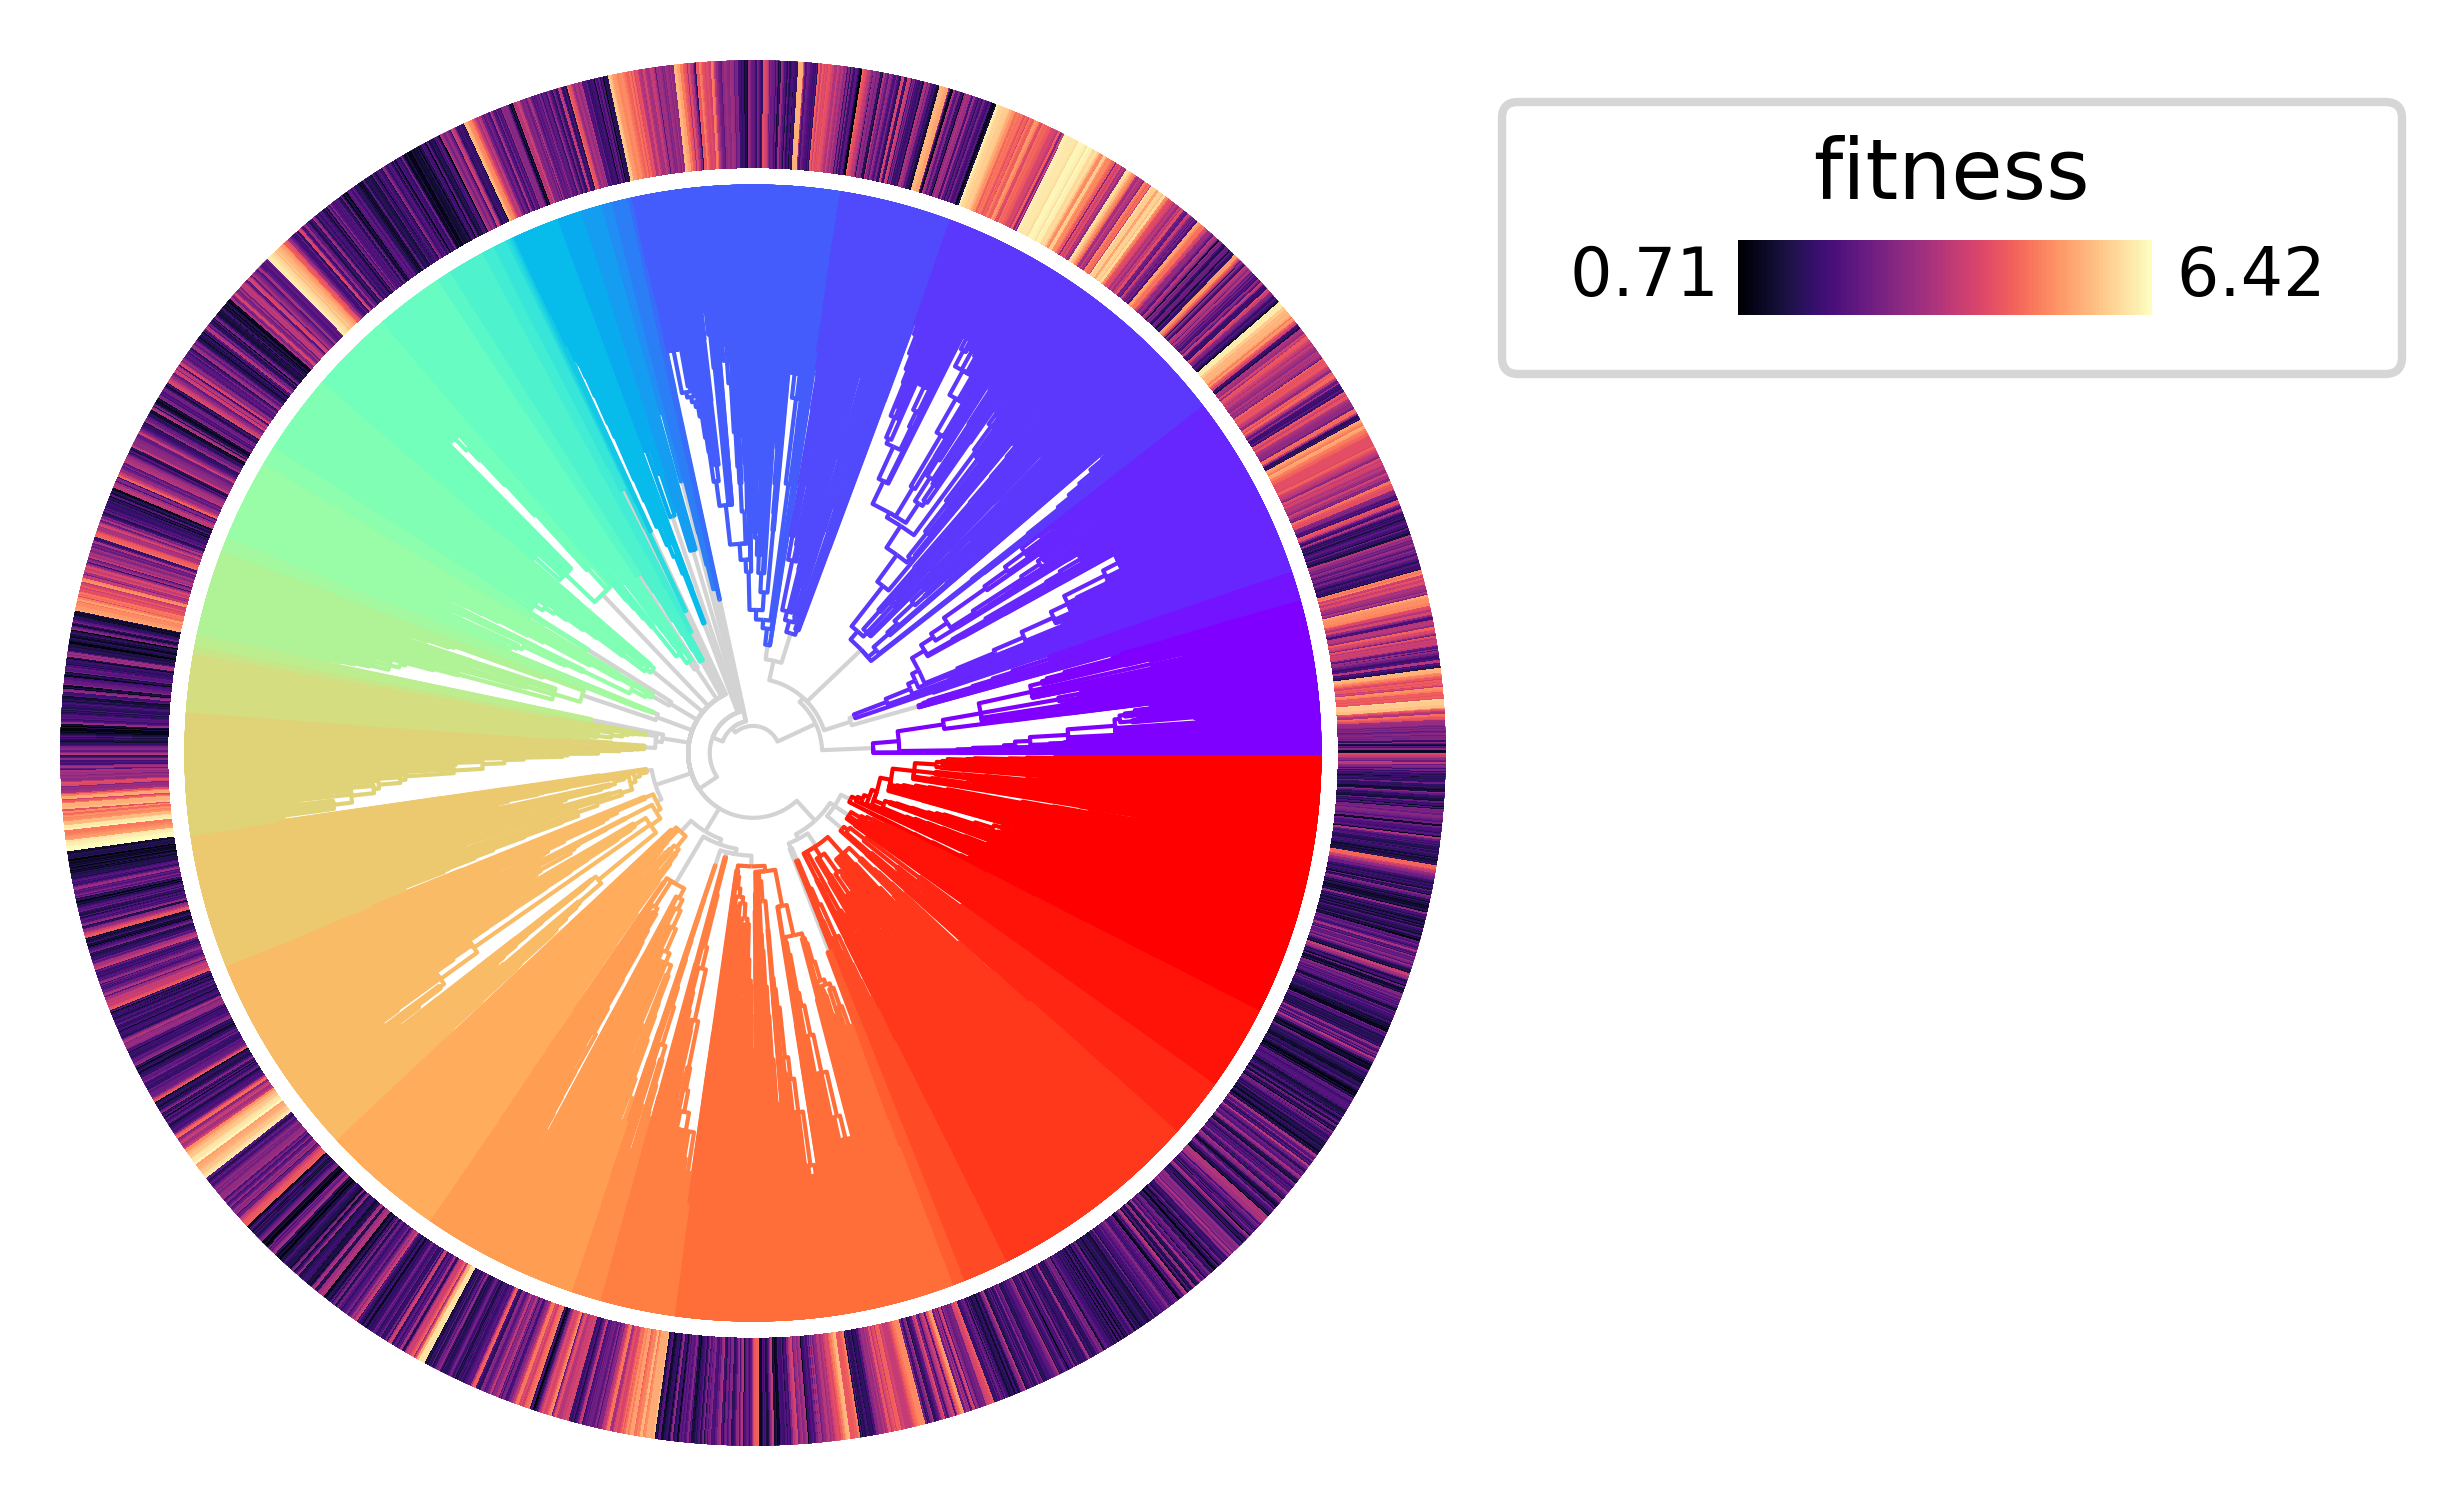

In [11]:
py.pl.tree(tdata, depth_key="time", branch_color="clade", palette=clade_palette, polar=True)
py.pl.annotation(tdata, keys="fitness", width=0.2, cmap="magma");

We can also visualize the spatial distribution of fitness values in each tumor section.

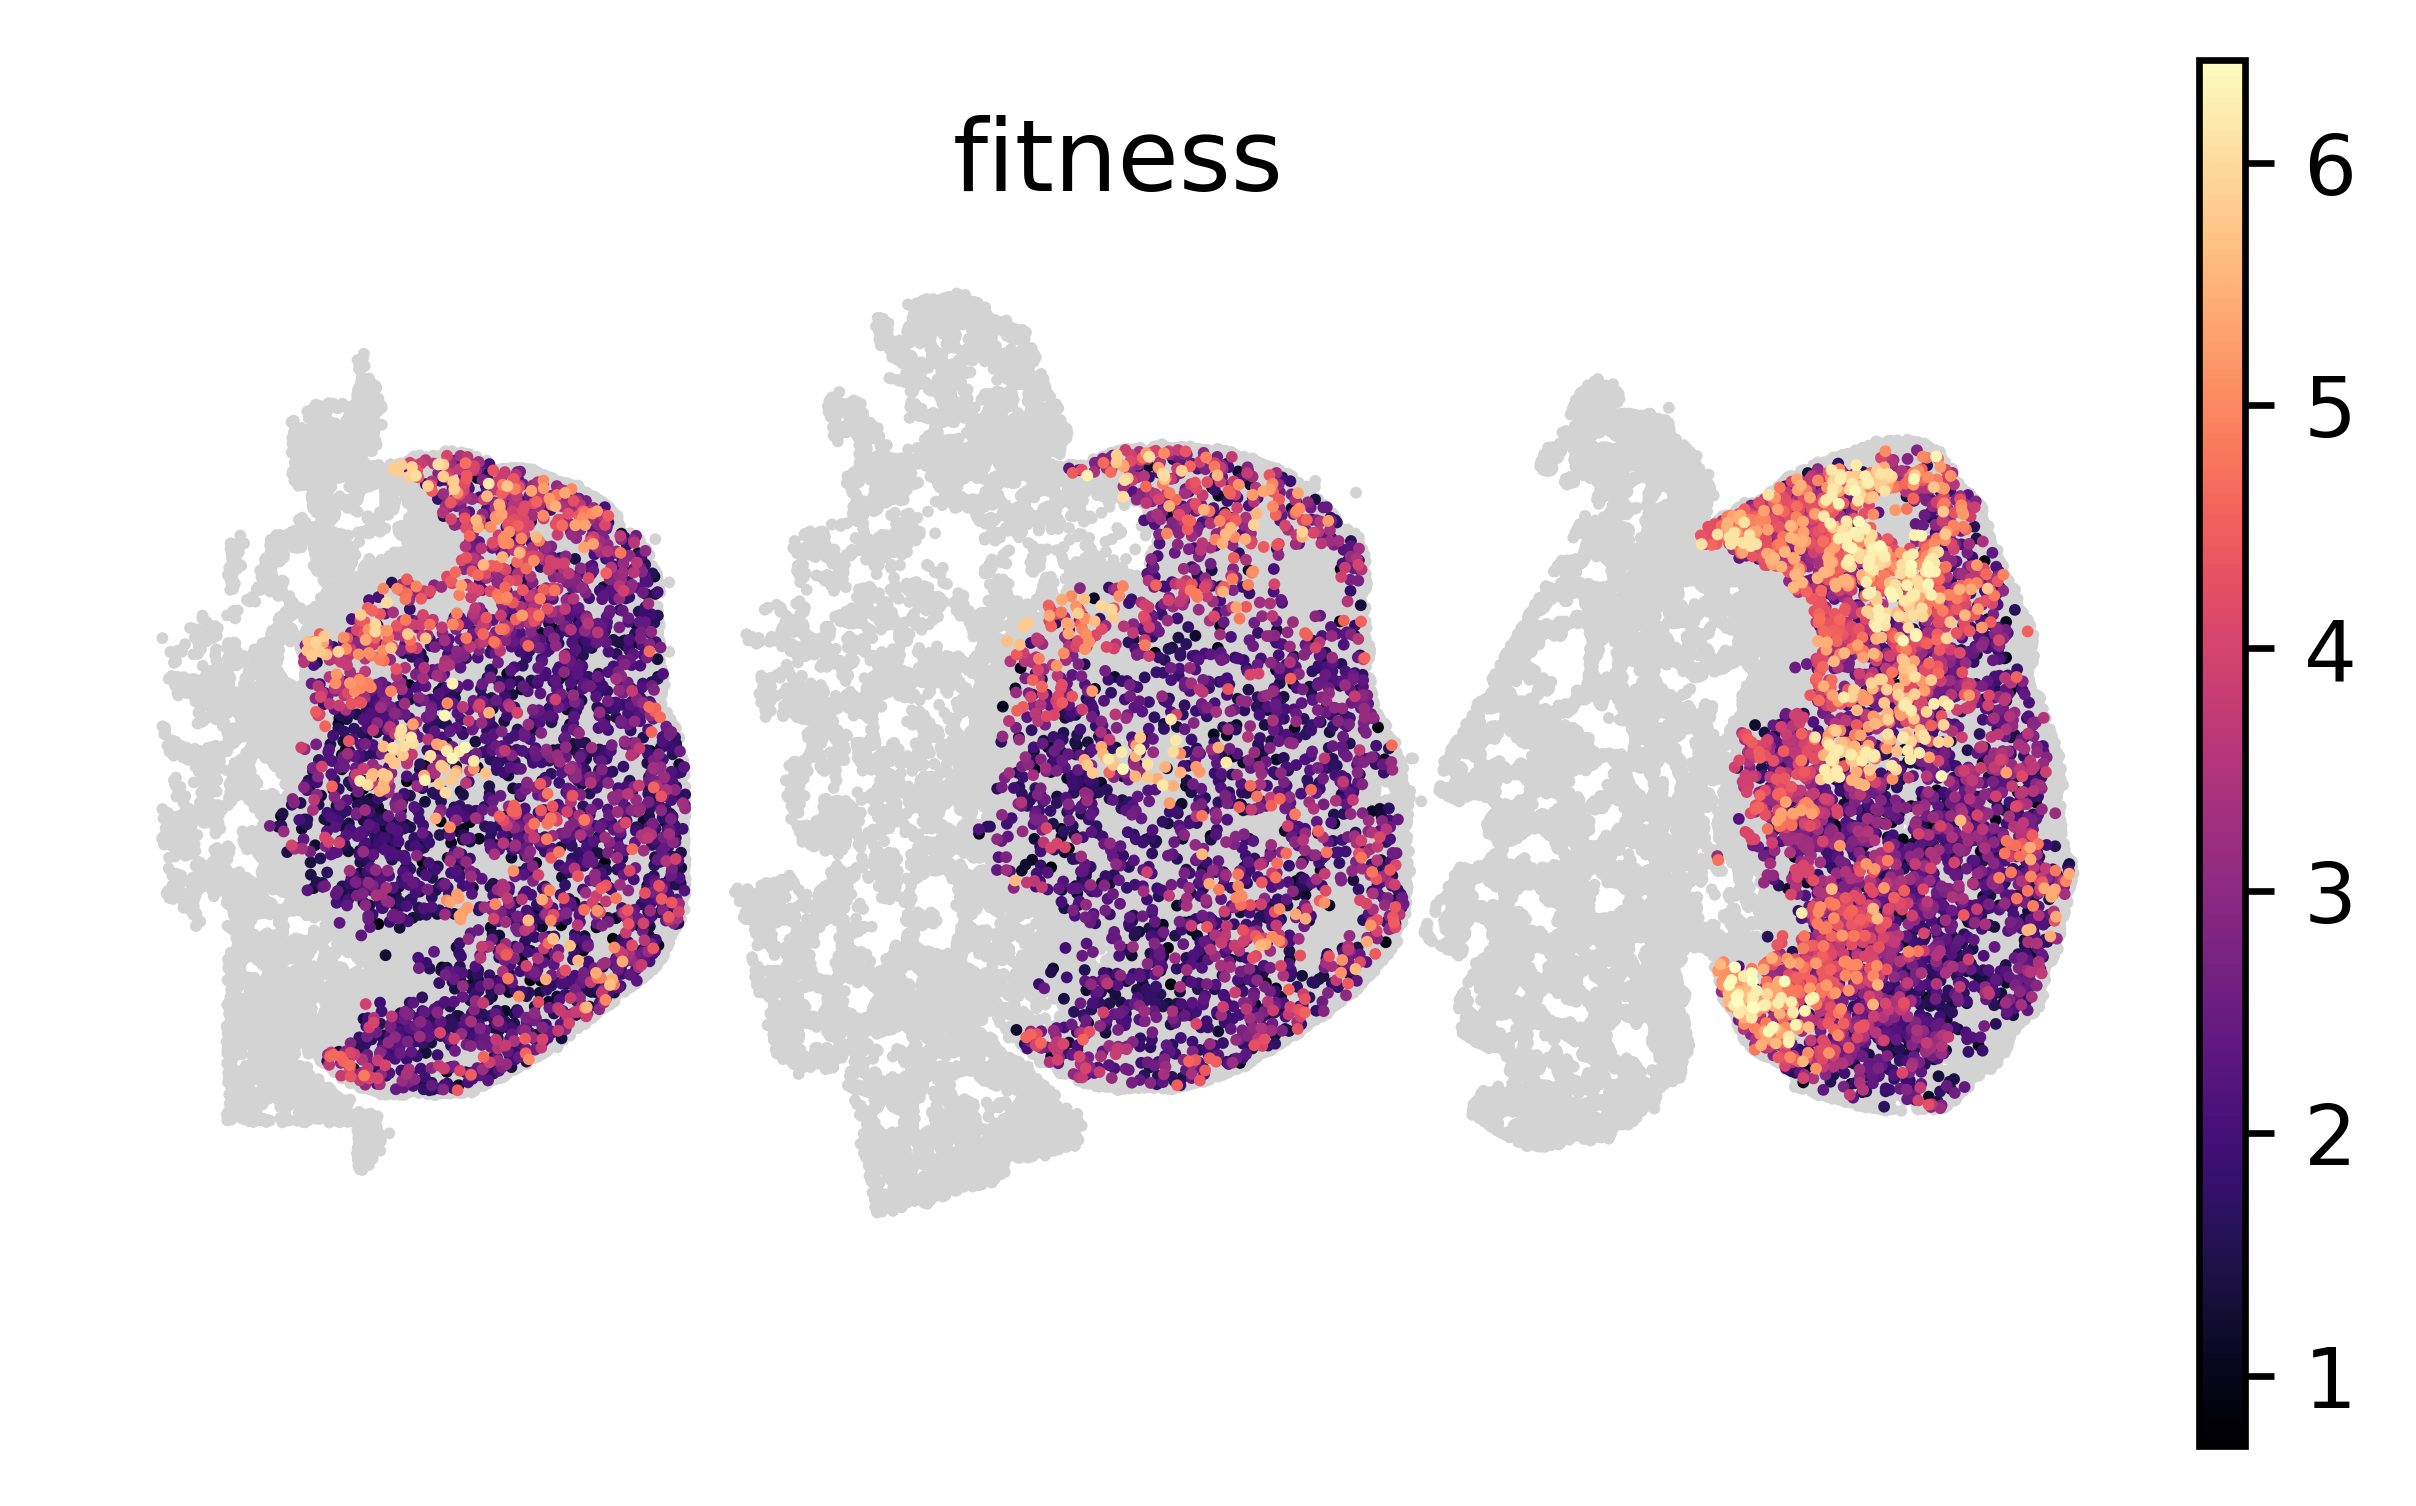

In [18]:
sc.pl.spatial(tdata, color="fitness", spot_size=40, frameon=False, cmap="magma");

## Fitness associated genes

To identify genes associated with fitness, we can compute the correlation between gene expression and fitness values.

In [19]:
expr = sc.get.obs_df(tdata, keys=list(tdata.var_names))
expr.corrwith(tdata.obs["fitness"]).sort_values(ascending=False).head(10)

Cldn4     0.152712
Lef1      0.120649
Fgfbp1    0.104217
Fgf1      0.101436
Ung       0.092184
Tcf7      0.078526
Cd300e    0.058376
Gpr141    0.057917
Itgb6     0.056766
Tubb1     0.056354
dtype: float64

The highest fitness clades also tend to have the highest expression of Cldn4

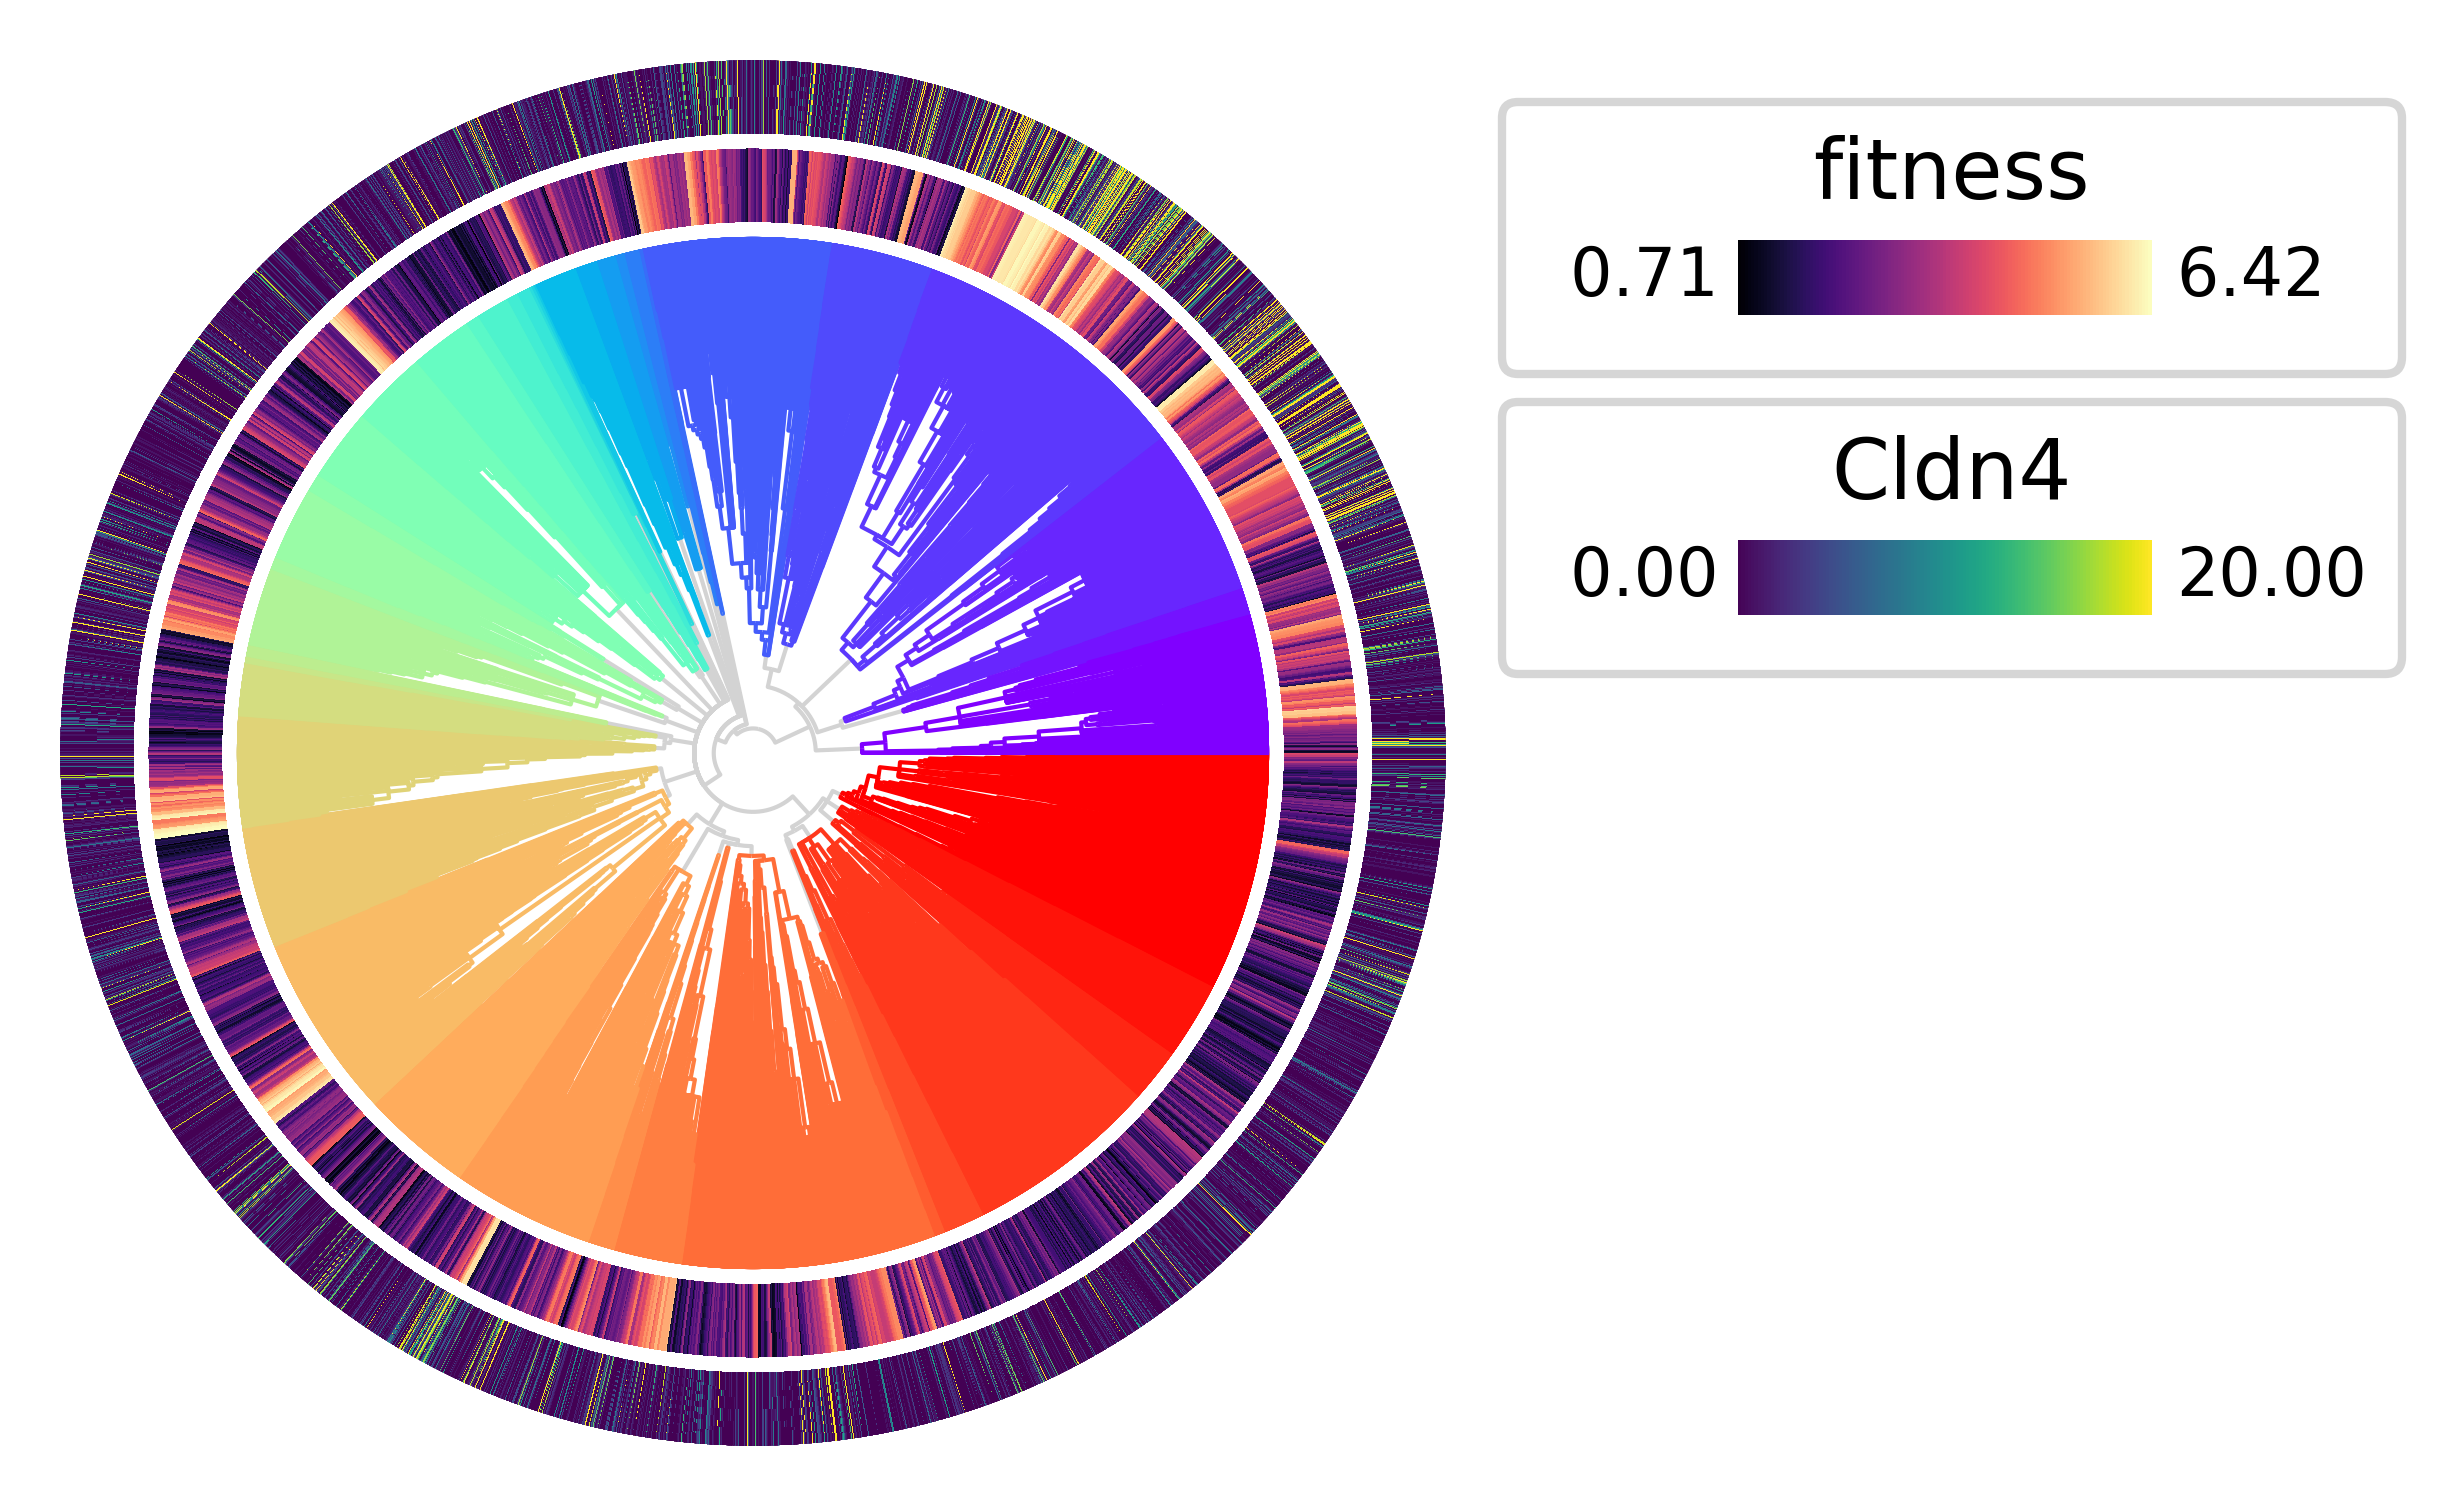

In [20]:
py.pl.tree(tdata, depth_key="time", branch_color="clade", palette=clade_palette, polar=True)
py.pl.annotation(tdata, keys="fitness", width=0.15, cmap="magma")
py.pl.annotation(tdata, keys="Cldn4", width=0.15, vmax=20);

## Expansion test

Pycea also implements the expansion test described by [Yang et al. 2022](https://www.sciencedirect.com/science/article/pii/S0092867422004627?via%3Dihub) to identify clades that are expanding more rapidly than expected under neutral growth. The {func}`pycea.tl.expansion_test` function computes expansion p-values for each node in the tree.

In [23]:
results = py.tl.expansion_test(tdata, copy=True).sort_values("expansion_pvalue")
results.head(10)

expansion_pvalue
node                       
node13229      2.529402e-08
node111        2.769561e-06
node5001       3.845089e-06
node19971      4.066291e-06
node179        4.328180e-06
node8257       4.914246e-06
node4177       1.410755e-05
node65         1.620056e-05
node10485      1.842842e-05
node15005      2.081252e-05

Let's highlight the top 10 most significant expansions in the tree.

<PolarAxes: >

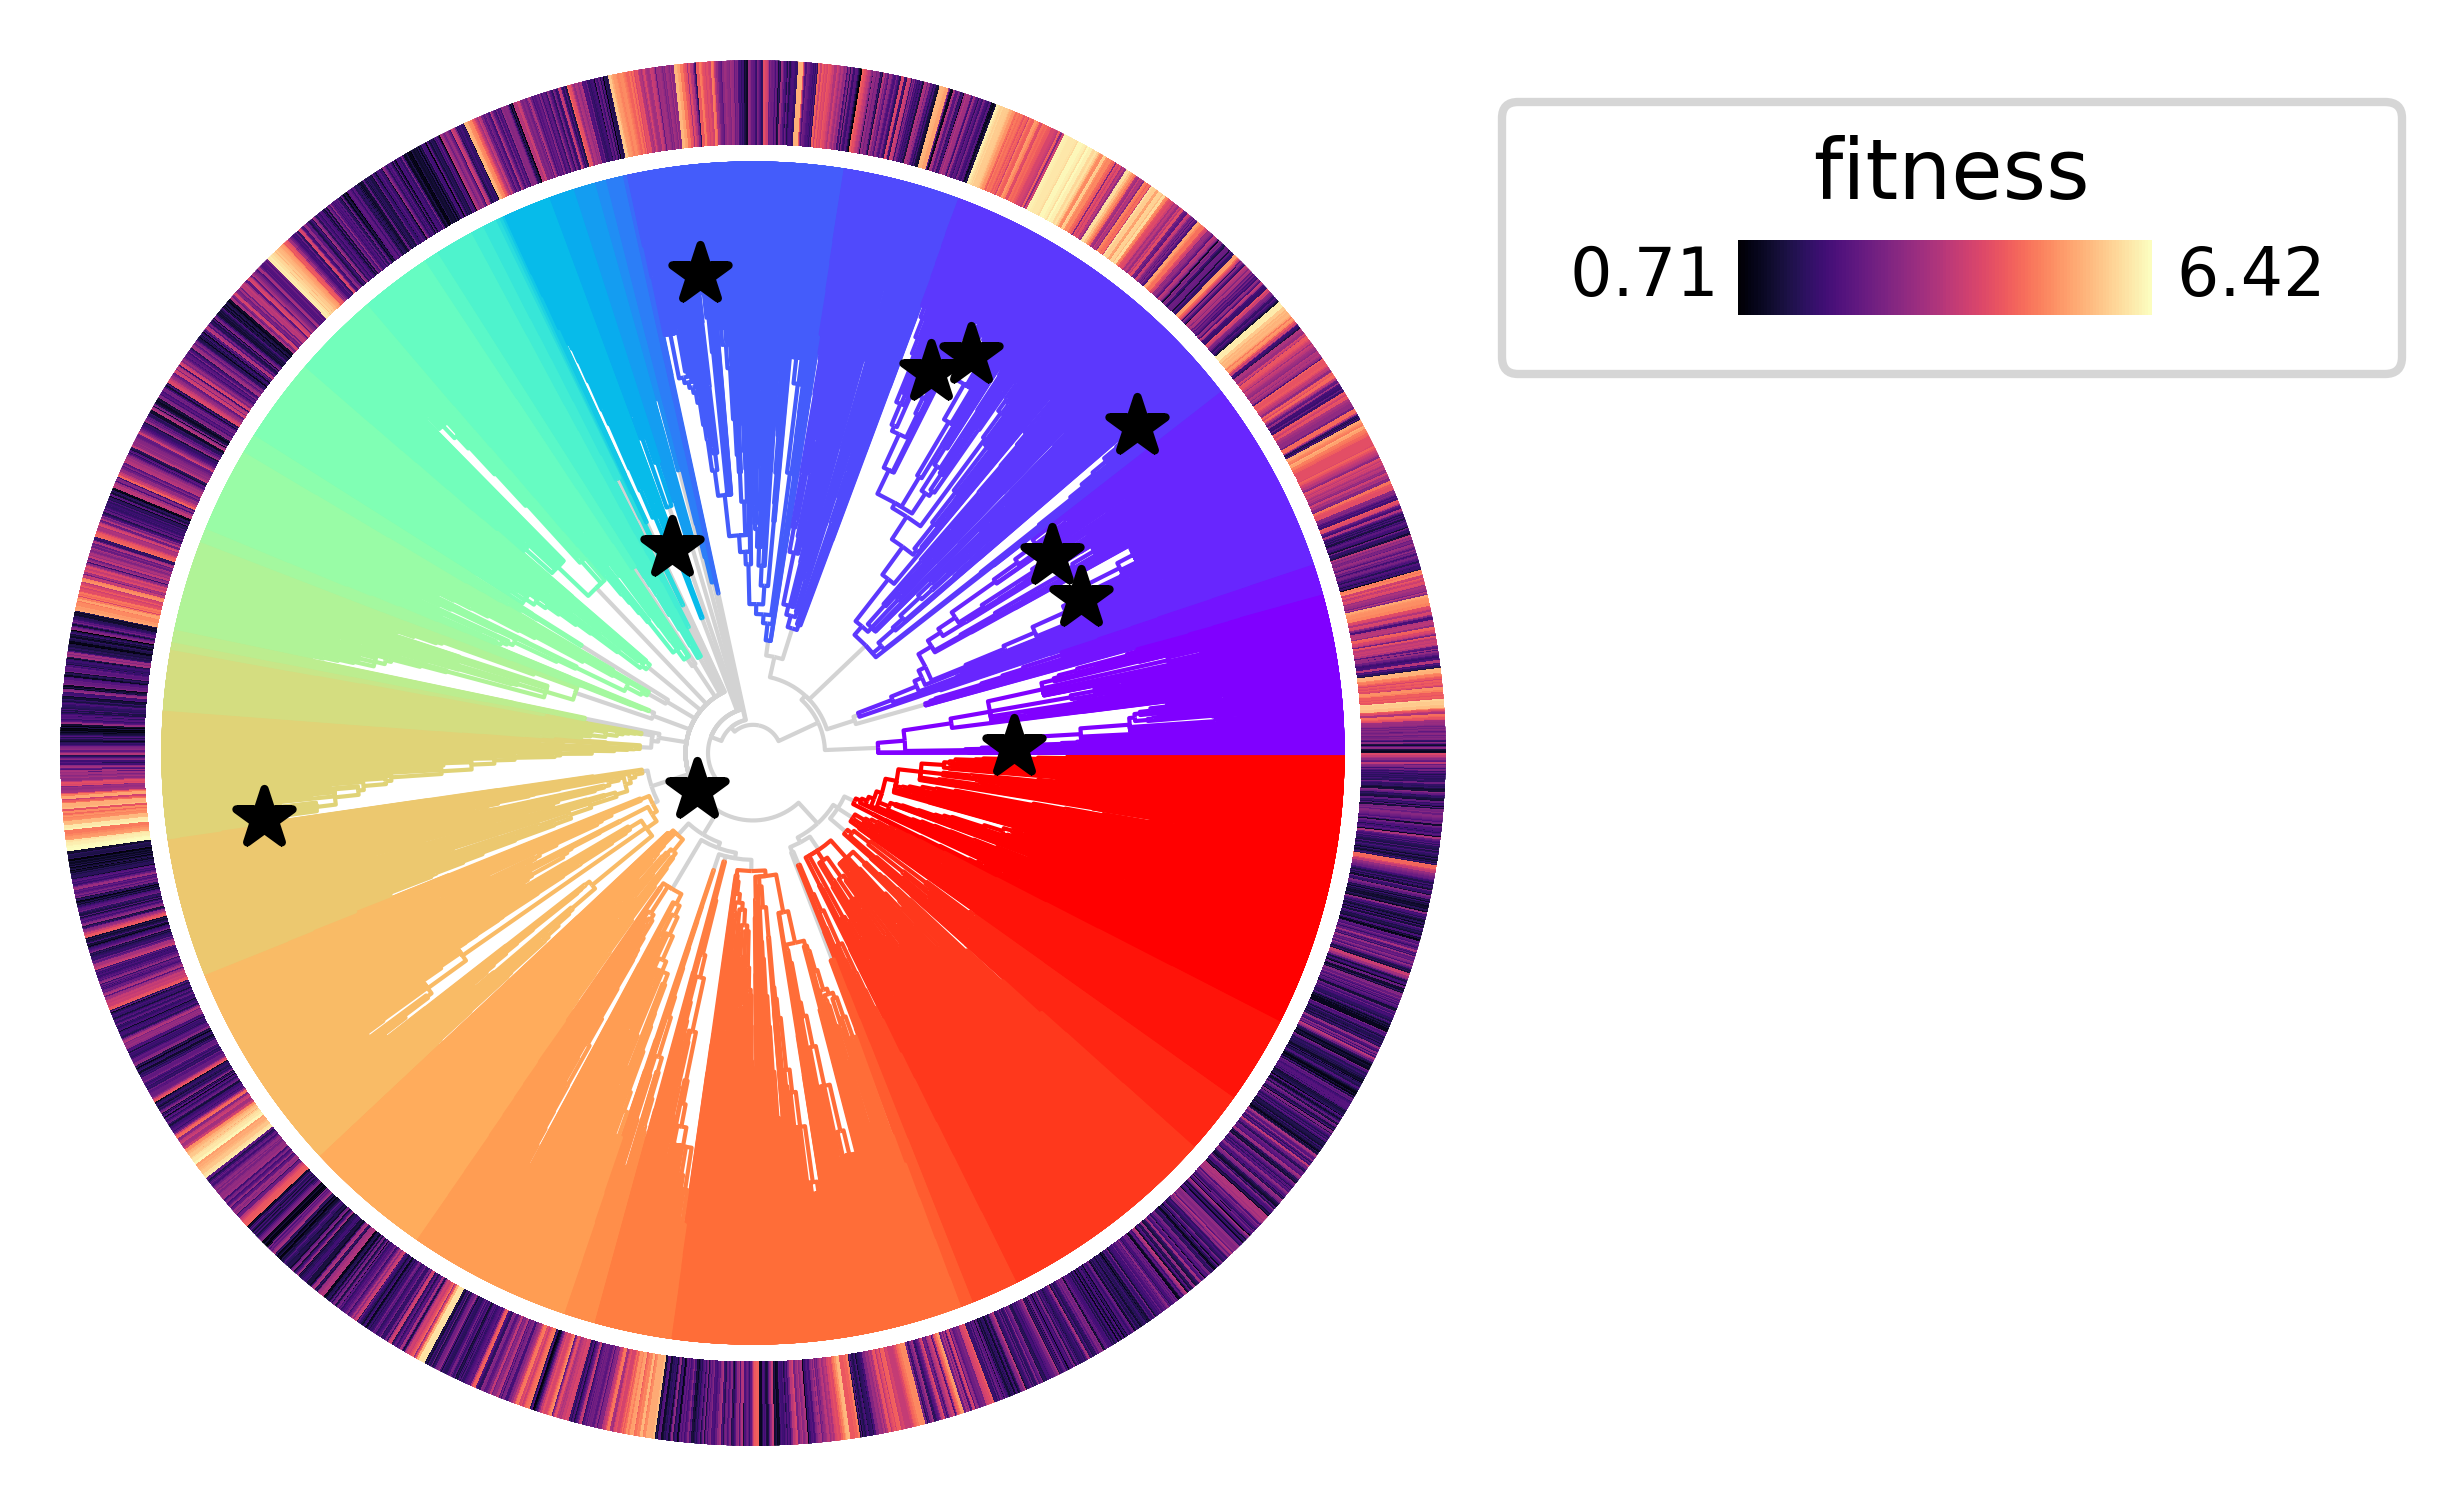

In [22]:
top_expansions = results.sort_values("expansion_pvalue").head(10).index.tolist()
py.pl.tree(tdata, depth_key="time", branch_color="clade", polar=True)
py.pl.annotation(tdata, keys="fitness", width=0.15, cmap="magma")
py.pl.nodes(tdata, nodes=top_expansions, style="*", size=50)